# `nb08a`: Model checking

In [30]:
import numpy as np
import matplotlib.pyplot as plt

Now that we can simulate data and fit models, we can evaluate the quality of a model and critically assess whether it is a good fit to data. This is called model checking.

# The light speed experiment 

In 1882, Simon Newcomb conducted an experiment to measure the speed of light. He used a rotating mirror to reflect a beam of light to a distant mirror and back. The time taken for the light to travel to the distant mirror and back was measured by timing the rotation of the mirror. The experiment was repeated several times, and the times taken for the light to travel to the distant mirror and back were recorded as deviations from 24,800 nanoseconds. 

In [31]:
# data
light_speed = np.array([28, 26, 33, 24, 34, -44, 27, 16, 40, -2, 29, 22, 24, 21, 25,
                        30, 23, 29, 31, 19, 24, 20, 36, 32, 36, 28, 25, 21, 28, 29,
                        37, 25, 28, 26, 30, 32, 36, 26, 30, 22, 36, 23, 27, 27, 28,
                        27, 31, 27, 26, 33, 26, 32, 32, 24, 39, 28, 24, 25, 32, 25,
                        29, 27, 28, 29, 16, 23]) 

len(light_speed)

66

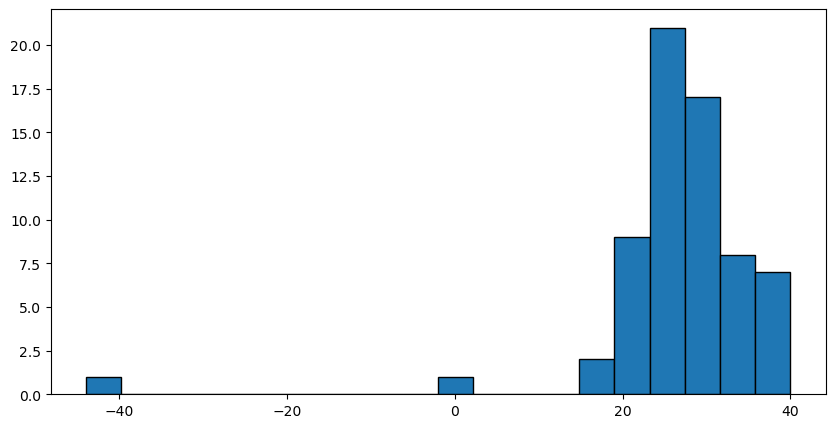

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.hist(light_speed, bins=20, edgecolor='black')
plt.show()

In [38]:
# model
from scipy.stats import norm, uniform

def log_likelihood(theta, x):
    return norm.logpdf(x, loc=theta[0], scale=theta[1]).sum()

def log_prior(theta):   
    return (uniform.logpdf(theta[0], loc=-1000, scale=2000) +  # p(mu) = U[-1000, 1000]
            uniform.logpdf(theta[1], loc=0.1, scale=1000))     # p(sigma) = U[0.1, 1000]

def log_posterior(theta, x):
    return log_likelihood(theta, x) + log_prior(theta) 

In [39]:
# posterior inference
import emcee
pos = np.array([10.0, 10.0]) + 0.1 * np.random.randn(10, 2)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(light_speed,))
sampler.run_mcmc(pos, 300000 // nwalkers, progress=True);

100%|██████████| 30000/30000 [00:59<00:00, 502.31it/s]


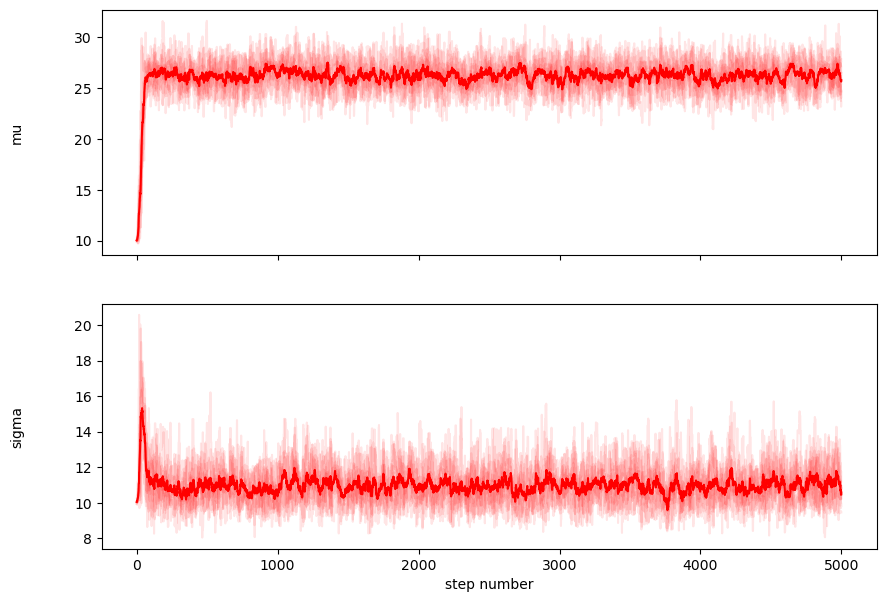

In [40]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:5000, :, i], "r", alpha=0.1)
    ax.plot(np.mean(samples[:5000, :, i], axis=1), "r", alpha=1.0)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

In [41]:
tau = sampler.get_autocorr_time()
tau

array([38.03271921, 35.13929752])

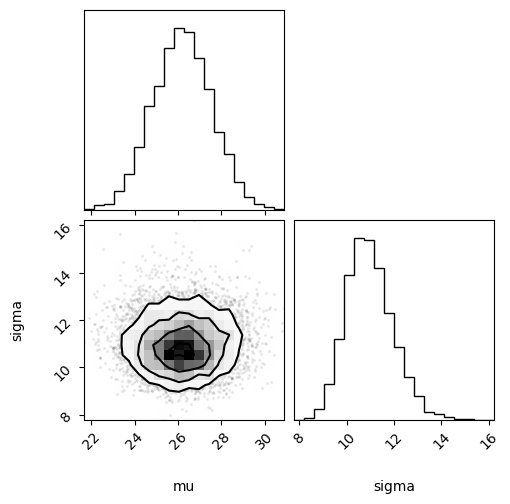

In [42]:
import corner
thetas = sampler.get_chain(flat=True, discard=500, thin=40)
fig = corner.corner(thetas, labels=labels)

In [43]:
print("E_p(mu|x)[mu] =", np.mean(thetas[:, 0]))
print("E_p(sigma|x)[sigma] =", np.mean(thetas[:, 1]))

E_p(mu|x)[mu] = 26.19861644319285
E_p(sigma|x)[sigma] = 10.970478006845552


In [44]:
print("Empirical mean =", np.mean(light_speed))
print("Empirical std =", np.std(light_speed))

Empirical mean = 26.21212121212121
Empirical std = 10.663610099255504


<div class="alert alert-success">
    
**Exercise**. Determine the 95% credibility interval for $\mu$ and $\sigma$.
    
</div>

A (highest posterior density) 95% credibility interval is the shortest interval that contains 95% of the posterior probability.

In [45]:
def hpd(trace, mass_frac) :
    d = np.sort(np.copy(trace))
    n = len(trace)
    n_samples = np.floor(mass_frac * n).astype(int)
    int_width = d[n_samples:] - d[:n-n_samples]
    min_int = np.argmin(int_width)
    return np.array([d[min_int], d[min_int+n_samples]])

low, high = hpd(thetas[:, 0], 0.95)
low, high

(23.623023131924313, 28.890786185718078)

In [46]:
24800+low, 24800+high

(24823.623023131924, 24828.89078618572)

Note: The currently accepted estimate of the speed of light under the conditions of the experiment corresponds to a measurement of 24833.02 nanoseconds.

# Posterior predictive distribution

$$p(x^\text{rep} | \{x\}) = \int p(x^\text{rep} | \theta) p(\theta | \{x\}) d\theta$$

In [48]:
thetas = thetas[:1000]

def pp(thetas):
    return norm.rvs(loc=thetas[:, 0], scale=thetas[:, 1])

$$p(\{x^\text{rep}\} | \{x\}) = \int p(\{x^\text{rep}\} | \theta) p(\theta | \{x\}) d\theta$$

In [49]:
def replicate(n_samples, thetas):
    x = np.zeros((n_samples, len(thetas)))
    
    for i in range(n_samples):
        x[i] = pp(thetas)
    
    return x

In [50]:
replicas = replicate(66, thetas)

In [51]:
replicas.shape

(66, 1000)

## Visual inspection of posterior predictives

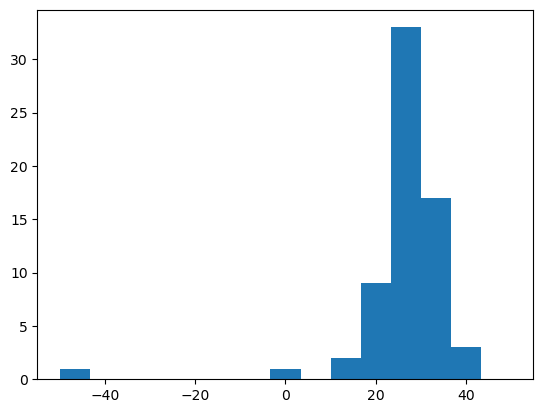

In [52]:
fig = plt.figure()
ax = plt.axes()
ax.hist(light_speed, bins=15, range=(-50, 50))
plt.show()

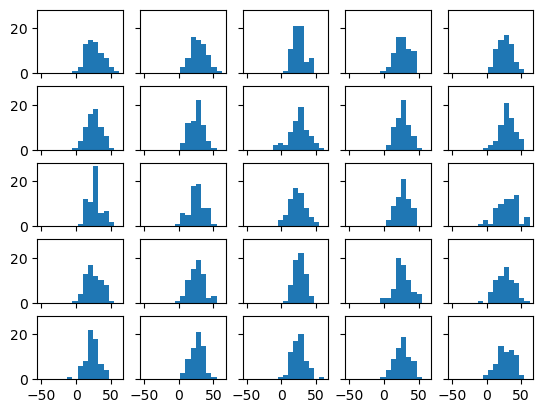

In [53]:
fig, ax = plt.subplots(5, 5, sharex=True, sharey=True)
lower = -50
upper = np.max(replicas[:, :25])
for k in range(25):
    ax[k // 5, k % 5].hist(replicas[:, k], bins=15, range=(lower, upper))
plt.show()

## Test quantities

Statistics 101: _There is only one test!_
1. Given the data, compute a test statistic that measures some aspect of the data.
2. Compute the distribution of the test statistic under the model.
3. Compare the observed test statistic to the distribution of the test statistic under the model, usually in terms of a p-value.

Forget about statistical recipes! They have been invented when computers were not available, i.e. when Step 2 was not something we could simply do by simulation.

In [54]:
light_speed.mean()

26.21212121212121

In [55]:
replicas.mean(axis=0)

array([25.8822815 , 28.21568261, 25.2494407 , 26.91140876, 26.41012265,
       25.78561618, 25.75208753, 25.86845283, 27.0494908 , 29.86351433,
       27.4703871 , 25.07581822, 23.4904406 , 26.93559936, 29.45972005,
       24.92930946, 26.19191955, 25.49409138, 26.7835059 , 26.57803445,
       22.87601173, 26.35189806, 24.73027694, 25.91454126, 27.18110108,
       28.14833959, 24.71465124, 22.20007805, 26.76414372, 27.53355446,
       28.75313263, 27.51752484, 25.96833484, 23.27523867, 25.48173515,
       24.64734369, 26.90441458, 25.45660092, 25.91122703, 27.75885584,
       25.32002253, 28.55723617, 25.56032307, 28.01101571, 24.76742957,
       22.45983518, 21.8836557 , 25.18905269, 28.08373043, 24.8376843 ,
       25.00895518, 27.05141043, 28.11919504, 28.13665901, 29.52280453,
       26.68976949, 25.72598393, 26.51221174, 26.35775103, 27.11908606,
       26.85937349, 27.30232062, 25.49348451, 25.8139777 , 26.12712162,
       25.30062478, 26.06694141, 24.88383616, 23.39805812, 25.69

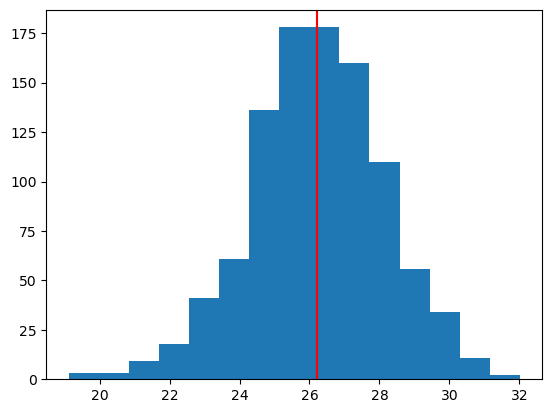

In [56]:
fig = plt.figure()
ax = plt.axes()

ax.hist(replicas.mean(axis=0), bins=15)
ax.axvline(light_speed.mean(), color="r")
        
plt.show()

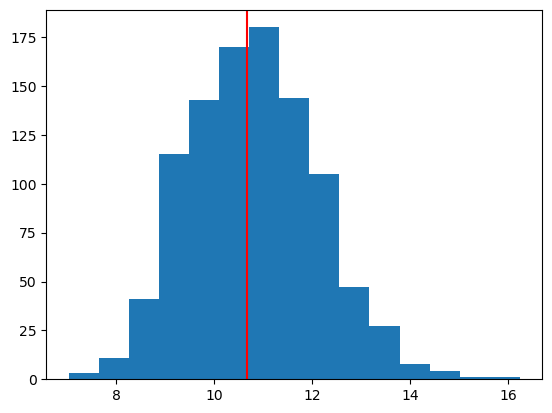

In [57]:
fig = plt.figure()
ax = plt.axes()

ax.hist(replicas.std(axis=0), bins=15)
ax.axvline(light_speed.std(), color="r")
        
plt.show()

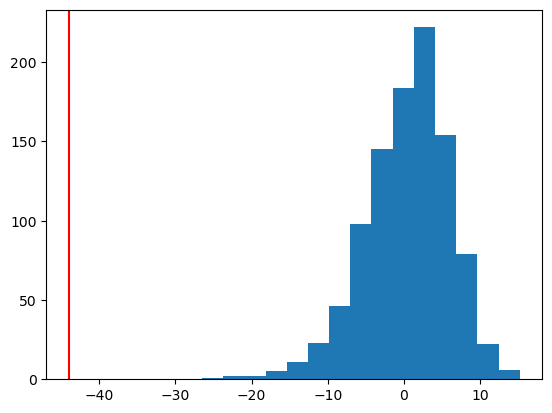

In [58]:
fig = plt.figure()
ax = plt.axes()

ax.hist(replicas.min(axis=0), bins=15)
ax.axvline(light_speed.min(), color="r")
        
plt.show()

In [59]:
np.mean(replicas.min(axis=0) >= light_speed.min())

1.0

This suggests that the normal distribution is not adequate to model the data. Its tails are too light.

## Bayesian p-values

Formally,
- $T(\{x\}, \theta)$ denotes a test quantity or discrepancy measure.
- $T(\{x\})$ denotes a test-statistic.

Classical p-values:
$$p_C = P(T(\{x^\text{rep}\}) \geq T(\{x\}) | \theta)$$

Bayesian p-values:
$$p_B = P(T(\{x^\text{rep}\}, \theta) \geq T(\{x\}, \theta) | \{ x \})$$

In [60]:
def T(xs, theta):
    xs = np.sort(xs)
    return np.abs(xs[60] - theta) - np.abs(xs[5] - theta)  # should scatter around 0 for a symmetric distribution

In [61]:
T_reps = []
T_x = []

for k in range(len(thetas)):
    T_reps.append(T(replicas[:, k], thetas[k, 0]))
    T_x.append(T(light_speed, thetas[k, 0]))
    
T_reps = np.array(T_reps)
T_x = np.array(T_x)

# T_reps is the test statistic for the replicas
# T_x is the test statistic for the original data 
# both are computed for the same value of theta

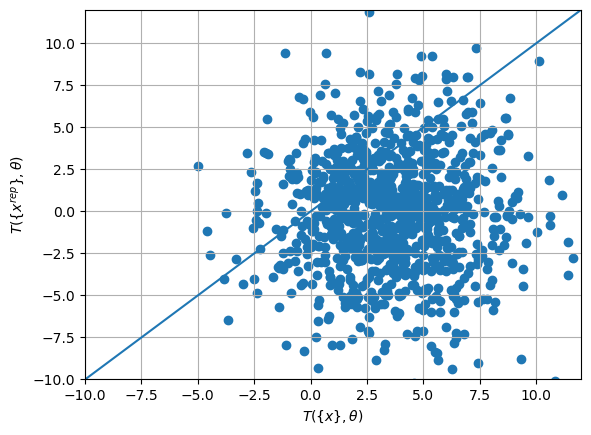

In [62]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(T_x, T_reps)
ax.plot([-10, 12], [-10, 12])
ax.set(xlim=(-10, 12), ylim=(-10,12), xlabel=r"$T(\{x\}, \theta)$", ylabel=r"$T(\{x^{rep}\}, \theta)$")
ax.grid()

plt.show()

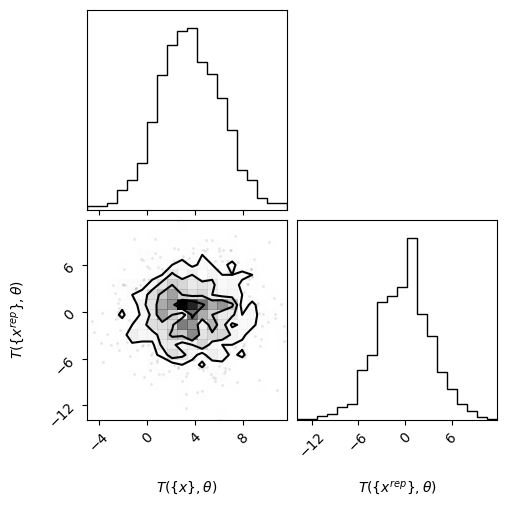

In [63]:
fig = corner.corner(np.hstack([T_x.reshape(-1, 1), T_reps.reshape(-1, 1)]), labels=[r"$T(\{x\}, \theta)$", r"$T(\{x^{rep}\}, \theta)$"])

In [64]:
np.mean(T_reps >= T_x)

0.2

_Gelman:_ "Finding an extreme p-value and thus ‘rejecting’ a model is
never the end of an analysis; the departures of the test quantity in
question from its posterior predictive distribution will often suggest
improvements of the model or places to check the data, as in the speed
of light example. Moreover, even when the current model seems
appropriate for drawing inferences (in that no unusual deviations
between the model and the data are found), the next scientific step will
often be a more rigorous experiment incorporating additional factors,
thereby providing better data."